## Variable binning

Notebook to make some tests of a variable binning scheme for the background model fit.

Author: Toby Dixon (toby.dixon.23@ucl.ac.uk)

In [10]:
import re
import pandas as pd
import uproot
import copy
import hist
import math
from legend_plot_style import LEGENDPlotStyle as lps
from datetime import datetime, timezone
from scipy.stats import poisson
from scipy.stats import norm
lps.use('legend')
import matplotlib.pyplot as plt
import numpy as np
import tol_colors as tc
from hist import Hist
import json
from legendmeta import LegendMetadata
import warnings
from iminuit import Minuit, cost
from scipy.stats import expon
from scipy.stats import truncnorm
from matplotlib.backends.backend_pdf import PdfPages
from numba import jit
import utils

%matplotlib inline
vset = tc.tol_cset('vibrant')



#### Binning algorithm
1. Take a list of gamma lines and place each in a single bin
    * Check there are no overlaps
2. Fill in the rest of the space with the continium binning 
    * Walk through the spectrum, if a new bin can be placed do it.
    * If distance to next bin < cont_binning/2 append this to the previous bin
    * If distance to next bin < cont_binning and > cont_binning/2 create a new bin

In [11]:
def insert_bin(bin_edge,bins):
    """ Add a bin edge to a sorted list (bin edges)"""
    insert_index = np.searchsorted(bins, bin_edge)
    sorted_array = np.insert(bins, insert_index, bin_edge)
    return sorted_array
def remove_bin(bin,bins):
    return bins[bins!=bin]

In [12]:
### a list of gamma lines


## start with a basic list of gamma lines
gamma_energies= np.array([583,609,911,1460,1525,1764,2204,2615])
low_energy=565
high_energy=4000
gamma_binning=10
cont_binning=15

bin_edges = np.array([low_energy,high_energy])
print(bin_edges)

for i in range(len(gamma_energies)):

    ### check first for overlaps
    energy = gamma_energies[i]
    if (i!=len(gamma_energies)-1):

        if (energy+gamma_binning/2>gamma_energies[i+1]-gamma_binning/2):
            raise ValueError("Error: Gamma lines are too close - revise")
    bin_edges=insert_bin(energy-gamma_binning/2,bin_edges)
    bin_edges=insert_bin(energy+gamma_binning/2,bin_edges)


bin_edges_only_gamma=bin_edges

### fill in the continuum
for i in range(len(bin_edges_only_gamma)-1):

    ### skip the first part of the gamma line pairs
    if (i%2==1):
        continue
    energy = bin_edges_only_gamma[i]
    proposed_new_bin=energy
    stop = False

    while not stop:
        proposed_new_bin +=cont_binning
        dist = abs(bin_edges_only_gamma[i+1]-(proposed_new_bin-cont_binning))
      
        if (proposed_new_bin<bin_edges_only_gamma[i+1]):
            bin_edges =insert_bin(proposed_new_bin,bin_edges)
        elif (proposed_new_bin>bin_edges_only_gamma[i+1] and dist<cont_binning/2):
            bin_edges=remove_bin(proposed_new_bin-cont_binning,bin_edges)
            stop=True
        else:           
            stop=True

print(bin_edges)

[ 565 4000]
[ 565  578  588  604  614  629  644  659  674  689  704  719  734  749
  764  779  794  809  824  839  854  869  884  906  916  931  946  961
  976  991 1006 1021 1036 1051 1066 1081 1096 1111 1126 1141 1156 1171
 1186 1201 1216 1231 1246 1261 1276 1291 1306 1321 1336 1351 1366 1381
 1396 1411 1426 1441 1455 1465 1480 1495 1510 1520 1530 1545 1560 1575
 1590 1605 1620 1635 1650 1665 1680 1695 1710 1725 1740 1759 1769 1784
 1799 1814 1829 1844 1859 1874 1889 1904 1919 1934 1949 1964 1979 1994
 2009 2024 2039 2054 2069 2084 2099 2114 2129 2144 2159 2174 2189 2199
 2209 2224 2239 2254 2269 2284 2299 2314 2329 2344 2359 2374 2389 2404
 2419 2434 2449 2464 2479 2494 2509 2524 2539 2554 2569 2584 2599 2610
 2620 2635 2650 2665 2680 2695 2710 2725 2740 2755 2770 2785 2800 2815
 2830 2845 2860 2875 2890 2905 2920 2935 2950 2965 2980 2995 3010 3025
 3040 3055 3070 3085 3100 3115 3130 3145 3160 3175 3190 3205 3220 3235
 3250 3265 3280 3295 3310 3325 3340 3355 3370 3385 3400 3415 3430

In [13]:
def bin_array_to_string(bin_array: np.ndarray) -> str:
    """
    Convert a NumPy array of bins into a string format representing bin sections.

    Parameters:
    - bin_array (np.ndarray): NumPy array of bin values.

    Returns:
    - str: A string in the format "low:bin:high" comma-separated, representing bin sections.
    """

    result = []
    current_start = bin_array[0]
    current_end = bin_array[0]
    current_diff = None

    for i in range(1, len(bin_array)):
        diff = bin_array[i] - bin_array[i - 1]

        if current_diff is None or diff == current_diff:
            current_diff = diff
            current_end = bin_array[i]
        else:
            result.append(f"{current_start}:{current_diff}:{bin_array[i - 1]}")
            current_start = bin_array[i-1]
            current_end = bin_array[i]
            current_diff = diff

    result.append(f"{current_start}:{current_diff}:{bin_array[-1]}")

    return ",".join(result)

In [14]:
print(bin_array_to_string(np.array([500,510,520,530,535,540,545,547,549,559,1000])))

500:10:530,530:5:545,545:2:549,549:10:559,559:441:1000


In [15]:
### get the binning string
widths= np.diff(bin_edges)
print(bin_array_to_string(bin_edges))


565:13:578,578:10:588,588:16:604,604:10:614,614:15:884,884:22:906,906:10:916,916:15:1441,1441:14:1455,1455:10:1465,1465:15:1510,1510:10:1530,1530:15:1740,1740:19:1759,1759:10:1769,1769:15:2189,2189:10:2209,2209:15:2599,2599:11:2610,2610:10:2620,2620:15:4000


In [16]:
def get_hist(obj):
    return obj.to_hist()


In [21]:
outfile="../hmixfit/results/hmixfit-l200a_vancouver_v0_5_rebin/histograms.root"


style = {
    "yerr": False,
    "flow": None,
    "lw": 0.6,
}


with uproot.open(outfile) as f:

    hist_icpc = get_hist(f["l200a_vancouver23_dataset_v0_2_icpc"]["originals"]["fitted_data"])
    hist_icpc_rebin=utils.variable_rebin(hist_icpc,bin_edges)
    hist_icpc_rebin=utils.normalise_histo(hist_icpc_rebin)
    hist_icpc=hist_icpc[500:3000][hist.rebin(5)]
    
print(hist_icpc)    
hist_icpc=utils.normalise_histo(hist_icpc)

                    ┌────────────────────────────────────────────────────────┐
[-inf,  500) 993384 │███████████████████████████████████████████████████████ │
[ 500,  505) 581    │                                                        │
[ 505,  510) 604    │                                                        │
[ 510,  515) 702    │                                                        │
[ 515,  520) 541    │                                                        │
[ 520,  525) 524    │                                                        │
[ 525,  530) 573    │                                                        │
[ 530,  535) 558    │                                                        │
[ 535,  540) 558    │                                                        │
[ 540,  545) 535    │                                                        │
[ 545,  550) 566    │                                                        │
[ 550,  555) 557    │                               

(1400.0, 1600.0)

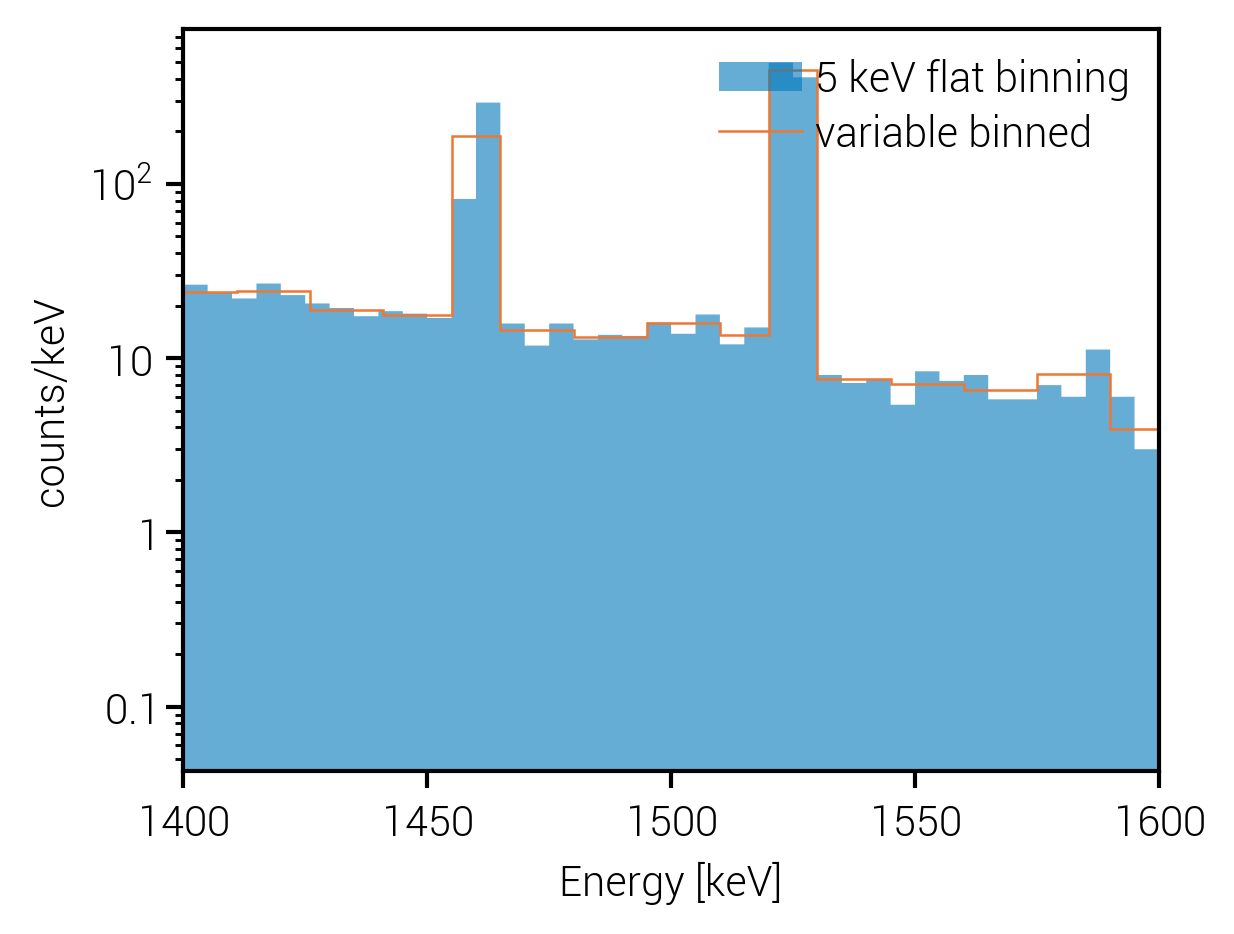

In [26]:
fig, axes_full = lps.subplots(1, 1, figsize=(4,3), sharex=True)
hist_icpc.plot(**style,ax=axes_full,color=vset.blue,histtype="fill",alpha=0.6,label="5 keV flat binning")
hist_icpc_rebin.plot(**style,ax=axes_full,color=vset.orange,label="variable binned")

axes_full.set_xlabel("Energy [keV]")
axes_full.set_ylabel("counts/keV")

axes_full.set_yscale("log")
axes_full.legend(loc="upper right")
axes_full.set_xlim(565,3000)
